# Use Pretrained Inception-BatchNorm Network
----

In this example we will demo how to use a pretrained Inception-BatchNorm Network. 

The network is described in 

Ioffe, Sergey, and Christian Szegedy. "Batch normalization: Accelerating deep network training by reducing internal covariate shift." arXiv preprint arXiv:1502.03167 (2015).

For network structure, you can visualize it in [Composite Symbol Demo](composite_symbol.ipynb)

The pre-trained Inception-BatchNorm network is able to be downloaded from:
[http://data.dmlc.ml/mxnet/data/Inception.zip](http://data.dmlc.ml/mxnet/data/Inception.zip)
This model achieves Top-1 Accuracy: 70% and Top-5 Accuracy: 89.9%

Note: This network is trained by using very simple augmentation (random flip + random crop). We will release model with a little bit more augmentation (which achieves better validation score)

In [1]:
%matplotlib inline
import mxnet as mx
import logging
import numpy as np
from skimage import io, transform

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
# Load the pre-trained model
prefix = "Inception/Inception_BN"
num_round = 39
model = mx.model.FeedForward.load(prefix, num_round, ctx=mx.gpu(), numpy_batch_size=1)

In [2]:
# load mean image
mean_img = mx.nd.load("Inception/mean_224.nd")["mean_img"]

In [3]:
# if you like, you can plot the network
# mx.viz.plot_network(model.symbol, shape={"data" : (1, 3, 224, 224)})

In [4]:
# load synset (text label)
synset = [l.strip() for l in open('Inception/synset.txt').readlines()]

Then we will show how to use this model to classify image. The image was taken in Notre-Dame Basilica, Montreal.

Original Image Shape:  (3648, 5472, 3)
Top1:  n07930864 cup
Top5:  ['n07930864 cup', 'n04330267 stove', 'n02948072 candle, taper, wax light', 'n04286575 spotlight, spot', 'n02815834 beaker']


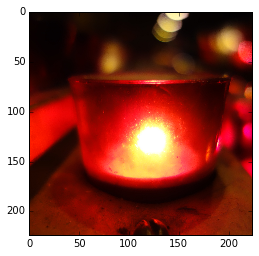

In [5]:
def PreprocessImage(path, show_img=False):
    # load image
    img = io.imread(path)
    print("Original Image Shape: ", img.shape)
    # we crop image from center
    short_egde = min(img.shape[:2])
    yy = int((img.shape[0] - short_egde) / 2)
    xx = int((img.shape[1] - short_egde) / 2)
    crop_img = img[yy : yy + short_egde, xx : xx + short_egde]
    # resize to 224, 224
    resized_img = transform.resize(crop_img, (224, 224))
    if show_img:
        io.imshow(resized_img)
    # convert to numpy.ndarray
    sample = np.asarray(resized_img) * 256
    # swap axes to make image from (224, 224, 4) to (3, 224, 224)
    sample = np.swapaxes(sample, 0, 2)
    sample = np.swapaxes(sample, 1, 2)
    # sub mean 
    normed_img = sample - mean_img.asnumpy()
    normed_img.resize(1, 3, 224, 224)
    return normed_img

# Get preprocessed batch (single image batch)
batch = PreprocessImage('./DSC01012.JPG', True)
# Get prediction probability of 1000 classes from model
prob = model.predict(batch)[0]
# Argsort, get prediction index from largest prob to lowest
pred = np.argsort(prob)[::-1]
# Get top1 label
top1 = synset[pred[0]]
print("Top1: ", top1)
# Get top5 label
top5 = [synset[pred[i]] for i in range(5)]
print("Top5: ", top5)

To extract feature, it is in similar to steps of [CIFAR-10](cifar-recipe.ipynb)

In [6]:
# get internals from model's symbol
internals = model.symbol.get_internals()
# get feature layer symbol out of internals
fea_symbol = internals["global_pool_output"]
# Make a new model by using an internal symbol. We can reuse all parameters from model we trained before
# In this case, we must set ```allow_extra_params``` to True
# Because we don't need params from FullyConnected symbol
feature_extractor = mx.model.FeedForward(ctx=mx.gpu(), symbol=fea_symbol, numpy_batch_size=1,
                                         arg_params=model.arg_params, aux_params=model.aux_params,
                                         allow_extra_params=True)
# predict feature
global_pooling_feature = feature_extractor.predict(batch)
print(global_pooling_feature.shape)

(1, 1024, 1, 1)
